In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import time

In [22]:
lambda_ = 2  # Poisson process parameter (mean number of parts broken per week)

def trans_prob(old_state, new_state, action):
    global lambda_
    prob = 0
    if old_state[0] == 0:
        if new_state[0] == action and new_state[1] == 7:
            prob = 1
    elif old_state[0] != 0:
        if new_state[1] == 0 and new_state[0] > action:
            num_broken_parts = old_state[0] + action - new_state[0]
            prob = stats.poisson.pmf(num_broken_parts, lambda_)
        elif new_state[1] != 0 and new_state[0] == action:
            if new_state[1] != 7:
                s = 0
                for k in range(old_state[0]):
                    s += (stats.poisson.pmf(k, (lambda_ / 7) * (7 - new_state[1])) *
                          stats.poisson.sf(old_state[0] - k - 1, lambda_ / 7))
                prob = s
            elif new_state[1] == 7:
                prob = stats.poisson.sf(old_state[0] - 1, lambda_ / 7)
    return prob


# testing input
s0 = np.array([3, 1])
s1 = np.array([0, 7])
s2 = np.array([3, 3])
s3 = np.array([6, 0])
a1 = 0
a2 = 3


print(trans_prob(s0, s1, a1))
print(trans_prob(s0, s2, a1))
print(trans_prob(s0, s3, a1))
print(trans_prob(s0, s1, a2))
print(trans_prob(s0, s2, a2))
print(trans_prob(s0, s3, a2))

0.0031423663287023142
0
0.0
0
0.065085167239262
0.1353352832366127


In [23]:
def cost_func(action, new_s, d=200, ppu=100, hpu=0.8, spdd=2400):
    if action == 0:
        ordering_cost = 0
    else:
        ordering_cost = d + ppu * action
    holding_and_shortage = new_s[0] * hpu + new_s[1] * spdd
    return ordering_cost + holding_and_shortage

In [24]:
def get_state_space(max_parts):
    ss = []
    for i in range(max_parts + 1):
        for j in range(8):  # j in 0 to 7
            if i == 0 and j == 0:
                continue
            ss.append((i, j))
    return np.array(ss)


def get_action_space(storage_cap, current_state):
    current_stor_cap = storage_cap - current_state[0]
    return np.arange(0, current_stor_cap + 1)


max_parts = 21
state_space = get_state_space(max_parts)

# testing
current = np.array([3, 1])  # Example current state
current_action_space = get_action_space(21, current)
print(len(state_space))
print(current_action_space)


175
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [25]:
cost_matrix = np.empty((max_parts + 1, len(state_space)))
for a in range(max_parts + 1):
    for j, state in enumerate(state_space):
        cost_matrix[a, j] = cost_func(a, state)

print(cost_matrix)

trans_prob_matrix = np.zeros((max_parts + 1, len(state_space), max_parts + 1))
for i in range(max_parts + 1):
    for j, s_new in enumerate(state_space):
        for a in range(max_parts + 1):
            trans_prob_matrix[i, j, a] = trans_prob((i, None), s_new, a)

# Check if the sum of probabilities for each old inventory level and action is 1
for i in range(max_parts + 1):
    for a in range(max_parts + 1 - i):
        total_prob = np.sum(trans_prob_matrix[i, :, a])
        print(f"Probability sum for old inventory level {i}, and action {a}: {total_prob:.6f}")


[[ 2400.   4800.   7200.  ... 12016.8 14416.8 16816.8]
 [ 2700.   5100.   7500.  ... 12316.8 14716.8 17116.8]
 [ 2800.   5200.   7600.  ... 12416.8 14816.8 17216.8]
 ...
 [ 4500.   6900.   9300.  ... 14116.8 16516.8 18916.8]
 [ 4600.   7000.   9400.  ... 14216.8 16616.8 19016.8]
 [ 4700.   7100.   9500.  ... 14316.8 16716.8 19116.8]]
Probability sum for old inventory level 0, and action 0: 1.000000
Probability sum for old inventory level 0, and action 1: 1.000000
Probability sum for old inventory level 0, and action 2: 1.000000
Probability sum for old inventory level 0, and action 3: 1.000000
Probability sum for old inventory level 0, and action 4: 1.000000
Probability sum for old inventory level 0, and action 5: 1.000000
Probability sum for old inventory level 0, and action 6: 1.000000
Probability sum for old inventory level 0, and action 7: 1.000000
Probability sum for old inventory level 0, and action 8: 1.000000
Probability sum for old inventory level 0, and action 9: 1.000000
Prob

In [26]:
def expected_action_value(current_state, action, state_space, values, cost_mat, trans_mat, discount_factor=0.995):
    probs = trans_mat[current_state[0], :, action]
    costs = cost_mat[action]
    return np.dot(probs, costs + discount_factor * values[state_space[:, 0]])

# testing the expected_action_value
current_state = (3, 1)
action = 2
expected_value = expected_action_value(current_state, action, state_space, values=np.zeros(max_parts + 1), 
                                       cost_mat=cost_matrix, trans_mat=trans_prob_matrix)
print(f"Expected value for action {action} in state {current_state}: {expected_value}")


Expected value for action 2 in state (3, 1): 2637.4643816465655


In [27]:
# Value iteration
error = 1e-6
values = np.zeros(max_parts + 1)
delta = 2 * error
counter = 0
elapsed = 0

state_first_coords = state_space[:, 0]

while delta >= error:
    start_time = time.time()
    delta = 0
    new_values = np.copy(values)
    for i in range(max_parts + 1):
        v = values[i]
        state = (i, None)
        action_space = get_action_space(max_parts, state)
        action_costs = np.array([
            expected_action_value(state, act, state_space, values, cost_matrix, trans_prob_matrix)
            for act in action_space
        ])
        values[i] = np.min(action_costs)
        delta = max(delta, abs(v - values[i]))
    counter += 1
    end_time = time.time()
    elapsed += end_time - start_time
    if counter % 100 == 0:
        avg_time = elapsed / 100
        print(f"Finished {counter} iterations \nCurrent delta = {delta}\n")
        print(f"{avg_time:.4f} seconds per iteration")
        print(values)
        print()
        elapsed = 0

print(values)

Finished 100 iterations 
Current delta = 219.54326277923246

0.0007 seconds per iteration
[55035.47208609 48747.02897281 43456.86626948 40348.86548194
 38841.48637068 38191.21638102 37907.30869704 37753.86306314
 37640.14766203 37537.1299367  37436.66514759 37337.29164137
 37231.70345051 37128.22329769 37026.11524425 36924.5903177
 36823.68283095 36723.44891285 36623.89423546 36525.0133863
 36426.80330469 36329.26237463]

Finished 200 iterations 
Current delta = 37.49711473599746

0.0007 seconds per iteration
[65357.26957497 59077.13688741 53792.96018841 50688.36606088
 49182.38686582 48532.5860148  48248.92107732 48095.54270285
 47981.84120054 47878.69615647 47778.0439985  47651.44723413
 47533.12142354 47417.11794402 47301.42986158 47186.25641144
 47071.77408939 46957.99690385 46844.91028641 46732.50870135
 46620.79089405 46509.75558535]

Finished 300 iterations 
Current delta = 6.263590084992757

0.0007 seconds per iteration
[67082.61244871 60804.40286884 55521.5489963  52417.675841

In [28]:
policy_records = []
for inventory_level in range(max_parts + 1):
    state = (inventory_level, None)
    action_space = get_action_space(max_parts, state)
    action_costs = np.array([
        expected_action_value(state, act, state_space, values, cost_matrix, trans_prob_matrix)
        for act in action_space
    ])
    order = action_space[np.argmin(action_costs)]
    policy_records.append((inventory_level, order))

policy_df = pd.DataFrame(policy_records, columns=["Inventory_level", "Order_size"])
print(policy_df)

    Inventory_level  Order_size
0                 0          21
1                 1          20
2                 2          19
3                 3          18
4                 4          17
5                 5          16
6                 6          15
7                 7          14
8                 8          13
9                 9          12
10               10          11
11               11           0
12               12           0
13               13           0
14               14           0
15               15           0
16               16           0
17               17           0
18               18           0
19               19           0
20               20           0
21               21           0


In [29]:
from scipy.optimize import curve_fit

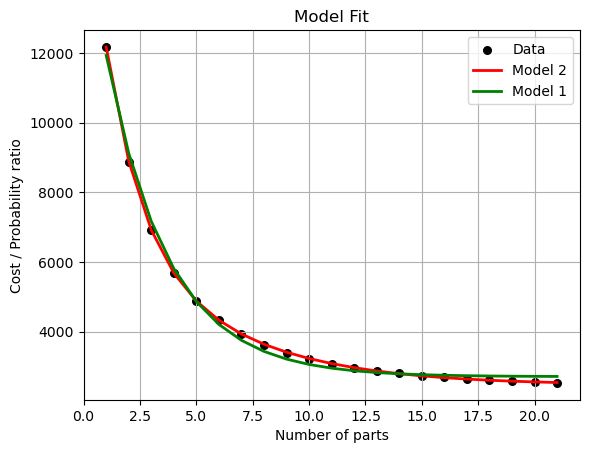

Parameters of model 1 (a * exp(-b * x) + c)
 [1.32606277e+04 3.63336143e-01 2.70687632e+03]
Parameters of model 2 (a * exp(-b * x) + d * x * exp(-e * x) + c)
 [1.52715735e+04 5.50748875e-01 1.18188020e+03 2.83859145e-01
 2.47473126e+03]


In [30]:
ratios = []
x = np.arange(1, max_parts + 1)
for num_parts in x:
    cost = 0
    for j in range(1, 8):
        cost += trans_prob((num_parts, 0), (0, j), 0) * \
                cost_func(0, (0, j))
    prob = stats.poisson.sf(num_parts - 1, lambda_)
    ratio = cost / prob if prob > 0 else np.nan
#   print(f"Number of starting parts: {num_parts}\nExpected cost: {cost}\n"
#         f"Probability of reaching zero: {prob}\nRatio: {ratio}\n")
    ratios.append(ratio)

x = x.astype(float)
y = np.array(ratios)

# First model: a * exp(-b * x) + c
def model1(x, a, b, c):
    return a * np.exp(-b * x) + c

# Second model: a * exp(-b * x) + d * x * exp(-e * x) + c
def model2(x, a, b, d, e, c):
    return a * np.exp(-b * x) + d * x * np.exp(-e * x) + c

popt1, _ = curve_fit(model1, x, y, p0=[10000, 0.2, 2000])
popt2, _ = curve_fit(model2, x, y, p0=[10000, 0.2, 1000, 0.1, 2000])

#
plt.scatter(x, y, label='Data', color='black', s=30)
plt.plot(x, model2(x, *popt2), color='red', linewidth=2, label='Model 2')
plt.plot(x, model1(x, *popt1), color='green', linewidth=2, label='Model 1')
plt.legend()
plt.xlabel("Number of parts")
plt.ylabel("Cost / Probability ratio")
plt.title("Model Fit")
plt.grid(True)
plt.show()

print("Parameters of model 1 (a * exp(-b * x) + c)\n", popt1)
print("Parameters of model 2 (a * exp(-b * x) + d * x * exp(-e * x) + c)\n", popt2)